In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect
from utils.constants import *
from datetime import datetime
import math
import statistics
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from pathlib import Path
from scipy.stats import norm, mannwhitneyu
import statistics


In [2]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

between = 0
duration = 1

special_between = {
    WINDOWS_OS : {
        CLAMP : 1
    }
}

language = "CSharp"

env = "PROD"

limit = 200

In [3]:
## OS
oses = [
    WINDOWS_OS,
    LINUX_OS
]

short_os = {
    WINDOWS_OS : "win",
    LINUX_OS : "lin"
}

In [4]:
## Test cases
test_cases = [
    IDLE_CASE,
    # DINING_PHILOSOPHERS,
    BINARY_TREE,
    # REVERSE_COMPLEMENT
    FANNKUCH_REDUX,
    NBODY,
    FASTA
]

short_test_case = {
    IDLE_CASE : "idle",
    DINING_PHILOSOPHERS : "din",
    BINARY_TREE : "bin",
    REVERSE_COMPLEMENT : "rev",
    FANNKUCH_REDUX : "fann",
    NBODY : "nbody",
    FASTA : "fasta"
}

In [5]:
## Profilers
profilers = [
    INTEL_POWER_GADGET,
    RAPL,
    HARDWARE_MONITOR,
    CLAMP,
    # E3
]

short_profilers = {
    INTEL_POWER_GADGET : "IPG",
    RAPL : "RA",
    HARDWARE_MONITOR : "HWM",
    E3 : "E3",
    CLAMP : "CL"
}

In [6]:
## DUT
duts = [
    SURFACE_4_PRO,
    SURFACE_BOOK,
    POWER_KOMPLETT
]

short_duts = {
    SURFACE_4_PRO : "pro",
    SURFACE_BOOK : "book",
    POWER_KOMPLETT : "pow",
}

dut_version = {
    SURFACE_BOOK : {
            WINDOWS_OS : 6,
            LINUX_OS : 3
        },
    SURFACE_4_PRO : {
        WINDOWS_OS : 12,
        LINUX_OS : 2,
    },
    POWER_KOMPLETT : {
        WINDOWS_OS : 8,
        LINUX_OS : 1,
    }
}

In [7]:
comparison_types = [PACKAGE_TOTAL, DRAM_TOTAL,CORE_TOTAL]

In [8]:
# repository = DataRepository()

# data = repository.get_experiments(
#         duts,
#         oses,
#         test_cases,
#         profilers,
#         dut_version,
#         min_temp,
#         max_temp,
#         min_battery,
#         max_battery,
#         duration,
#         between,
#         env,
#         language,
#         special_between
#     )

# repository.close()
# %store data

In [9]:
%store -r

In [10]:
data.keys()
data['PowerKomplett'].keys()
data['PowerKomplett']['Win32NT'].keys()
# data['PowerKomplett']['Win32NT']['TestCaseIdle'].keys()
# data['PowerKomplett']['Win32NT']['TestCaseIdle']['IntelPowerGadget'].keys()
# experiment = data['PowerKomplett']['Win32NT']['TestCaseIdle']['IntelPowerGadget']['experiment']
# for e in experiment.experiments:
#     print(e.CumulativeProcessorEnergyInJoules)


dict_keys(['TestCaseIdle', 'BinaryTrees', 'FannkuchRedux', 'Nbody', 'Fasta'])

In [11]:
class ExpDataPoint(object):
    def __init__(self, exp_id, consumption, runs, duration):
        self.exp_id = exp_id
        self.x = consumption/ runs
        self.y = duration / runs
    
    def set_id(self, id):
        self.id = id
    
    def get_tuple(self):
        return (self.x, self.y)

    def set_distance_to_k(self, value):
        self.dist = value

def find_outliers(experiments, k, points_to_look_back, profiler, y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, min_sampels=4, show_graphs=False):
    exp_data_points = [] #here 

    for e in experiments:
        if profiler == INTEL_POWER_GADGET:
            power = e.CumulativeProcessorEnergyInJoules
        elif profiler == HARDWARE_MONITOR:
            power = e.cpuPowerPacketTotalJ
        elif profiler == RAPL:
            power = e.CoreStopInJoules - e.CoreStartInJoules
        elif profiler == CLAMP:
            power = e.TrueRMS
        else:
            raise Exception("profiler not implemented") ## ipg CumulativeProcessorEnergyInJoules, TrueRMS, x.CoreStopInJoules - x.CoreStartInJoules
        
        exp_data_points.append(ExpDataPoint(
            e.id, power, e.runs, e.duration
        ))
    
    # if show_graphs:
    #     plt.scatter(*zip(*(x.get_tuple() for x in exp_data_points)))
    #     plt.show()
    
    for p1 in exp_data_points:
        dists = []
        for p2 in exp_data_points:
            if p1.exp_id == p2.exp_id:
                dists.append(math.inf)
            else:
                dists.append(math.dist(p1.get_tuple(), p2.get_tuple()))
        sorted_by_second = sorted(dists, key=lambda tup: tup)
        p1.set_distance_to_k(sorted_by_second[k])
    
    exp_data_points = sorted(exp_data_points, key=lambda tup: tup.dist)
    
    for i in range(len(exp_data_points)):
        exp_data_points[i].set_id(i)

    if show_graphs:
        plt.scatter(*zip(*((x.id, x.dist) for x in exp_data_points)))

        plt.show()
    
    eps = exp_data_points[-points_to_look_back].dist
    min_sampels = 4
    
    data_arr = np.array([x.get_tuple() for x in exp_data_points])
    
    dbscan = DBSCAN(eps = eps, min_samples = min_sampels)
    pred = dbscan.fit_predict(data_arr)
    anom_index = np.where(pred == -1)
    values = data_arr[anom_index]

    if show_graphs:
        plt.scatter(data_arr[:,0], data_arr[:,1])
        plt.scatter(values[:,0], values[:,1], color='r')
        if use_x_lim:
            plt.xlim(x_min, x_max)
        if use_y_lim:
            plt.ylim(y_min,y_max)
        plt.show()

    points_to_remove = []

    for v in values:
        for e in exp_data_points:
            tup = (v[0], v[1])
            
            if tup == e.get_tuple():
                points_to_remove.append(e)
                break

    #print(f"{len(points_to_remove)} points were removed")
                
    # for p in points_to_remove:
    #     print(f"{p.exp_id} - {p.get_tuple()}")
    
    return [x.exp_id for x in points_to_remove]
    

In [12]:
data[SURFACE_4_PRO][WINDOWS_OS][IDLE_CASE][INTEL_POWER_GADGET]["contains_data"] #here


True

In [13]:
for d in duts: #here
    for o in oses:
        for t in test_cases:
            for p in profilers:
                if data[d][o][t][p]["contains_data"]:
                    ee = data[d][o][t][p]["experiment"]
                    removed_points = find_outliers(ee.experiments, ee.k, ee.look_back, p, 0, 0, 0, 0, False, False, min_sampels=4, show_graphs=False)
                    
                    for e in ee.experiments:
                        if e.id in removed_points:
                            e.is_outlier = True
                        else:
                            e.is_outlier = False

In [14]:
def GetData(experiments, profiler, raw = False):
    data = []
    for e in experiments:
        if(not raw):
            r = e.runs
        else:
            r = 1 

        if profiler == INTEL_POWER_GADGET:
            power = e.CumulativeProcessorEnergyInJoules/r
        elif profiler == HARDWARE_MONITOR:
            power = e.cpuPowerPacketTotalJ/r
        elif profiler == RAPL:
            power = (e.CoreStopInJoules - e.CoreStartInJoules)/r
        elif profiler == CLAMP:
            power = e.TrueRMS/r
        else:
            raise Exception("profiler not implemented") ## ipg CumulativeProcessorEnergyInJoules, TrueRMS, x.CoreStopInJoules - x.CoreStartInJoules
        data.append(power)  
    return data

### Testing for normal distribution (Sharpiro Wilk)

In [15]:
from scipy import stats
def NormDist(experiments, pval, profiler):
    data = GetData(experiments,profiler)
    shapiro_test = stats.shapiro(data)
    if(shapiro_test.pvalue <= pval):
        return True
    else:
        return False    

In [16]:
def PlotNormalDist(data,p):
    NumData = GetData(data,p)

    NumData.sort()
    NumData = NumData[:-2]
    mu, std = norm.fit(NumData) 


    plt.hist(NumData, bins=5, density=True, alpha=0.6, color='b')
    # plt.ylabel('some numbers')
    # plt.show()
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()

In [17]:
NormDists = []
for d in duts: #here
    for o in oses:
        for t in test_cases:
            for p in profilers:
                if data[d][o][t][p]["contains_data"]:
                    ee = data[d][o][t][p]["experiment"]
                    NormDists.append((NormDist([x for x in ee.experiments if x.is_outlier == False], 0.05,p), p,t,o,d))
                    #print([x[0] for x in NormDists])
                    #PlotNormalDist([x for x in ee.experiments if x.is_outlier == False],p)

Most of the distributions are normally distributed, but not all because of this the statistical methods will have to be able to handle both normally and non-normally distributed data.

### Checking if data is part of the same distribution(mannwhitneyu)

In [18]:
def MannwhitneyTest(data1,data2,pval,profiler1, profiler2):
    dist1 = GetData(data1,profiler1)
    dist2 = GetData(data2,profiler2)
    nx, ny = len(dist1), len(dist2)
    U1, p = mannwhitneyu(dist1, dist2, method="asymptotic")
    U2 = nx*ny - U1
    if(p <= pval):
        #return (True, U1, U2, p)
        return p
    else:
        #return (False, U1, U2, p)
        return p

In [19]:
#dict_keys(['TestCaseIdle', 'BinaryTrees', 'FannkuchRedux', 'Nbody', 'Fasta'])
Idle = []
Fasta = []
Binary = []
Fannkuch = []
Nbody = []
Fasta = []
for d in duts: #here
    for o in oses:
        for t in test_cases:
            if(t == IDLE_CASE):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Idle.append((data[d][o][t][p]["experiment"],d,o,t,p))
            elif(t == BINARY_TREE):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Binary.append((data[d][o][t][p]["experiment"],d,o,t,p))
            elif(t == FANNKUCH_REDUX):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Fannkuch.append((data[d][o][t][p]["experiment"],d,o,t,p))
            elif(t == NBODY):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Nbody.append((data[d][o][t][p]["experiment"],d,o,t,p))
            elif(t == FASTA):
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        Binary.append((data[d][o][t][p]["experiment"],d,o,t,p))
            else:
                raise Exception("Test case not found")

In [33]:
def PlotHeat(ExtractedData,keys,test_case = "test"):
    import numpy as np
    import matplotlib
    import matplotlib as mpl
    import matplotlib.pyplot as plt

    vegetables = keys #Y axis
    farmers = keys #X axis


    harvest = np.array(ExtractedData)


    fig, ax = plt.subplots()
    im = ax.imshow(harvest)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(farmers)), labels=farmers)
    ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(vegetables)):
        for j in range(len(farmers)):
            text = ax.text(j, i, harvest[i, j],
                        ha="center", va="center", color="w")

    ax.set_title(test_case)
    fig.tight_layout()
    plt.show()

In [34]:
Binary[0]

(<utils.objects.Experiment at 0x1ef050722f0>,
 'Surface4Pro',
 'Win32NT',
 'BinaryTrees',
 'IntelPowerGadget')

[1.0, 1.8535267635085654e-42, 6.416675761728916e-41, 7.378401277502693e-42, 4.670924145535513e-44, 2.89618689628324e-41, 3.658319828588521e-42, 3.060871141055852e-20, 2.49467726299882e-43, 1.9547175711912427e-41]
[1.8535267635085654e-42, 1.0, 4.0837737908470733e-42, 2.563925627571129e-16, 1.5874399123287846e-42, 1.799232277051369e-42, 2.288151423336384e-43, 2.340252566196286e-43, 2.49467726299882e-43, 1.1999405437470518e-42]
[6.416675761728916e-41, 4.0837737908470733e-42, 1.0, 1.6201016858870004e-41, 1.6201016858870004e-41, 3.3812647824394447e-41, 9.766908677012088e-35, 2.8423445989420737e-38, 7.143875795425793e-41, 2.3369757738495724e-41]
[7.378401277502693e-42, 2.563925627571129e-16, 1.6201016858870004e-41, 1.0, 4.144112745065988e-42, 7.481358317776405e-42, 1.1440377941649645e-42, 1.1440377941649645e-42, 1.6201016858870004e-41, 5.107809132556647e-42]
[4.670924145535513e-44, 1.5874399123287846e-42, 1.6201016858870004e-41, 4.144112745065988e-42, 1.0, 7.481358317776405e-42, 1.1440377941

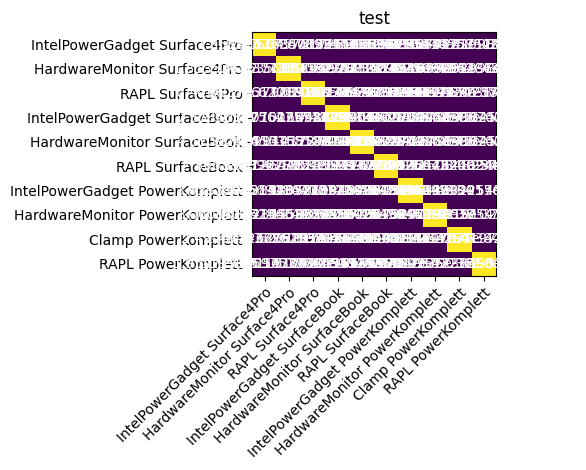

In [35]:
#IDLE                    print(ee.experiments[0].is_outlier)
def GetKey(obj):
    return obj[4]+" "+obj[1]

def calcVal(x,y):
    return MannwhitneyTest(x[0].experiments,y[0].experiments, 0.05, x[4], y[4])

def GetLines(obj):
    result = []
    for k in obj.keys():
        result.append(GetLine(obj[k]))
    return result

def GetLine(obj):
    results = []
    for k in obj.keys():
        results.append(obj[k])
    print(results)
    return results

keys = {}
TestCase = Idle
for x in TestCase:
    keys[GetKey(x)] = {}
    for y in TestCase:
        keys[GetKey(x)][GetKey(y)] = calcVal(x,y) 

results = GetLines(keys)
PlotHeat(results,keys.keys())

In [36]:
keys

{'IntelPowerGadget Surface4Pro': {'IntelPowerGadget Surface4Pro': 1.0,
  'HardwareMonitor Surface4Pro': 1.8535267635085654e-42,
  'RAPL Surface4Pro': 6.416675761728916e-41,
  'IntelPowerGadget SurfaceBook': 7.378401277502693e-42,
  'HardwareMonitor SurfaceBook': 4.670924145535513e-44,
  'RAPL SurfaceBook': 2.89618689628324e-41,
  'IntelPowerGadget PowerKomplett': 3.658319828588521e-42,
  'HardwareMonitor PowerKomplett': 3.060871141055852e-20,
  'Clamp PowerKomplett': 2.49467726299882e-43,
  'RAPL PowerKomplett': 1.9547175711912427e-41},
 'HardwareMonitor Surface4Pro': {'IntelPowerGadget Surface4Pro': 1.8535267635085654e-42,
  'HardwareMonitor Surface4Pro': 1.0,
  'RAPL Surface4Pro': 4.0837737908470733e-42,
  'IntelPowerGadget SurfaceBook': 2.563925627571129e-16,
  'HardwareMonitor SurfaceBook': 1.5874399123287846e-42,
  'RAPL SurfaceBook': 1.799232277051369e-42,
  'IntelPowerGadget PowerKomplett': 2.288151423336384e-43,
  'HardwareMonitor PowerKomplett': 2.340252566196286e-43,
  'Clamp

In [37]:
len(pairs)

NameError: name 'pairs' is not defined